In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lib.SciTech2022_inference import current_model
from lib.esi_surrogate import forward

In [5]:
# Deterministic emitter array
Nr = 1  # number of realizations
Ne = 576  # number of emitters
Nv = 1000  # number of voltages to evaluate at

# Model parameters (zeta_1, zeta_2, b_0)
params = np.array([1.17815344, 7.34716087e-03, 7.00033136e-06])
# params = np.array([2.57, 1.69e-2, 2e-5])

# Voltage prediction locations
voltage = np.linspace(0, 2000, Nv)

# Substrate properties
rp = np.mean([5e-6, 8e-6])  # pore radius [m]
kappa = 1.51e-13  # permittivity [m^-2]
subs = np.array([[rp], [kappa]])
subs.reshape(2, Nr)

# Material properties
k = np.mean([1.147, 1.39])  # conductivity [Sm^-1]
gamma = np.mean([5.003e-2, 5.045e-2])  # surface tension [N/m]
rho = np.mean([1.28e3, 1.284e3])  # density [kg/m^3]
mu = np.mean([2.612e-2, 3.416e-2])  # viscosity [N-s/m^2]
props = np.array([k, gamma, rho, mu]).T.reshape(4, Nr)

# Propellant properties
qm_ratio = 5.5e5  # charge to mass ratio [C/kg]
beams = np.array([qm_ratio]).reshape(1, Nr)

# Geometry parameters
rc = np.mean([1e-5, 2e-5])
d = 3e-6
ra = 2.486e-4
alpha = 2.678e-1
h = 3.018e-4
rpl = 6.5e-7
geoms = np.array([rc, d, ra, alpha, h, rpl])
geoms = np.tile(geoms[:, np.newaxis], (1, Ne)).reshape(6, Ne, Nr)

# Get surrogate electric field solution
emitter_geo = np.array([d, rc, alpha, h, ra])
V0 = 1000
Emax = forward(emitter_geo, net_file='../lib/esi_surrogate.onnx', V0=V0)
# es_model = np.ones((1,Ne,Nr))*Emax / V0
es_model = np.ones((1, Ne, Nr)) * (4.614e7 / V0)

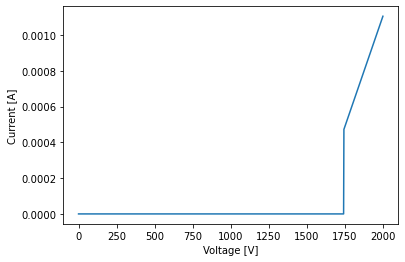

In [6]:
current = current_model(params, voltage, subs, props, beams, geoms, es_models=es_model)
fig = plt.figure()
plt.plot(voltage, current)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

In [2]:
def geom_sampler(Ne, Nr):
    rc = np.random.rand(1, Ne, Nr) * (2e-5 - 1e-5) + 1e-5
    d = np.random.randn(1, Ne, Nr) * 5.23e-6 + 3e-6
    ra = np.random.randn(1, Ne, Nr) * 3.596e-6 + 2.486e-4
    alpha = np.random.randn(1, Ne, Nr) * 4e-3 + 0.2678
    h = np.random.randn(1, Ne, Nr) * 5.13e-6 + 3.018e-4
    rp = np.random.randn(1, Ne, Nr) * 7.5e-8 + 6.5e-7
    samples = np.concatenate((rc, d, ra, alpha, h, rp), axis=0)
    return samples  # (6, Ne, Nr)

def beam_sampler(Nr):
    qm_ratio = np.random.randn(1, Nr) * 1.003e4 + 5.5e5
    return qm_ratio  # (1, Nr)

def prop_sampler(Nr):
    k = np.random.rand(1, Nr) * (1.39 - 1.147) + 1.147
    gamma = np.random.rand(1, Nr) * (5.045e-2 - 5.003e-2) + 5.003e-2
    rho = np.random.rand(1, Nr) * (1.284e3 - 1.28e3) + 1.28e3
    mu = np.random.rand(1, Nr) * (3.416e-2 - 2.612e-2) + 2.612e-2
    props = np.concatenate((k, gamma, rho, mu), axis=0)
    return props  # (4, Nr)

def subs_sampler(Nr):
    # rpr = np.random.rand(1, Nr) * (8e-6 - 5e-6) + 5e-6
    rpr = np.ones((1, Nr)) * 8e-6
    kappa = np.random.randn(1, Nr) * 6.04e-15 + 1.51e-13
    subs = np.concatenate((rpr, kappa), axis=0)
    return subs  # (2, Nr)

In [3]:
Nr = 100  # number of realizations
Ne = 576  # number of emitters
Nv = 50  # number of voltages to evaluate at

# Model parameters (zeta_1, zeta_2, b_0)
# params = np.array([2.71, 1.94e-2, 1.93e-5])
# params = np.array([2.71, 0.0155, 1.88e-5])
params = np.array([2.57, 1.69e-2, 2e-5])

# Voltage prediction locations
voltage = np.linspace(800, 1840, Nv)

# Nuisance parameters
subs = subs_sampler(Nr)
props = prop_sampler(Nr)
beams = beam_sampler(Nr)
# geoms = geom_sampler(Ne, Nr)
#
# # Get surrogate electric field solution
# rc = geoms[0, :, :].flatten()
# d = geoms[1, :, :].flatten()
# ra = geoms[2, :, :].flatten()
# alpha = geoms[3, :, :].flatten()
# h = geoms[4, :, :].flatten()
# x = np.vstack((d, rc, alpha, h, ra))
#
# V0 = 1000
# Emax = forward(x, net_file='../lib/esi_surrogate.onnx', V0=V0)
# es_model = Emax.reshape(1, Ne, Nr) / V0

geoms = np.loadtxt('../data/mr_geoms.dat', dtype=float, delimiter='\t').T.reshape(6, Ne, Nr)
emax_sim = np.loadtxt('../data/mr_geoms_tipE.dat', dtype=float, delimiter='\t').reshape(1, Ne, Nr)

# rc = geoms[0, :, :].flatten()
# d = geoms[1, :, :].flatten()
# ra = geoms[2, :, :].flatten()
# alpha = geoms[3, :, :].flatten()
# h = geoms[4, :, :].flatten()
# x = np.vstack((d, rc, alpha, h, ra))
# V0 = 1000
# emax_surr = forward(x, net_file='../lib/esi_surrogate.onnx', V0=V0) / V0
# e_sim = emax_sim.flatten()
# rel_error = np.divide(emax_surr - e_sim, e_sim) * 100
# plt.figure()
# plt.hist(rel_error, density=True, bins=50, edgecolor='black')
# plt.xlabel('Relative error (%)')
# plt.ylabel('PDF')
# plt.show()

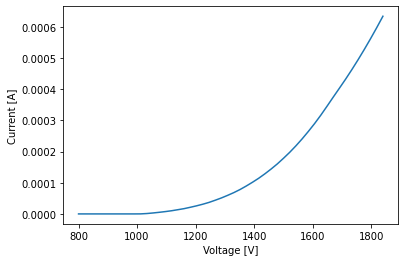

In [6]:
current = current_model(params, voltage, subs, props, beams, geoms, es_models=emax_sim)
mean_curr = np.mean(current, axis=1)
plt.figure()
plt.plot(voltage, mean_curr)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

In [90]:
exp_data = np.loadtxt('../data/training_data.txt', dtype=float, delimiter='\t')
# plt.figure()
# plt.errorbar(exp_data[0, :], exp_data[1, :], yerr=np.sqrt(exp_data[2,:]), fmt='ko', markerfacecolor='none')
# plt.xlabel('Voltage [V]')
# plt.ylabel('Current [A]')
# plt.show()

params = np.loadtxt('../data/Nr100_noPr_samples__2021_12_07T11_41_27.txt', dtype=float, delimiter='\t', skiprows=1)
# fig, axs, gs = scatter_matrix([params], hist_plot=True, gamma=0.8, labels=[r'$\zeta_1$',r'$\zeta_2$',r'$b_0$'],
#                                   specials=[{"vals":np.mean(params,axis=0),"color":'r'}])
# fig.set_size_inches(7,7)
# plt.subplots_adjust(left=0.01, right=0.99, wspace=0.1, hspace=0.1)

In [123]:
def batch_normal_pdf(x, mu, cov):
    """
    Compute the multivariate normal pdf at each x location.
    Dimensions
    ----------
    d: dimension of the problem
    *: any arbitrary shape (a1, a2, ...)
    Parameters
    ----------
    x: (*, d) location to compute the multivariate normal pdf
    mu: (*, d) mean values to use at each x location
    cov: (d, d) covariance matrix, assumed same at all locations
    Returns
    -------
    pdf: (*) the multivariate normal pdf at each x location
    """
    # Make some checks on input
    x = np.atleast_1d(x)
    mu = np.atleast_1d(mu)
    cov = np.atleast_1d(cov)
    dim = cov.shape[0]

    # 1-D case
    if dim == 1:
        cov = cov[:, np.newaxis]    # (1, 1)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    if len(mu.shape) == 1:
        mu = mu[:, np.newaxis]

    assert cov.shape[0] == cov.shape[1] == dim
    assert x.shape[-1] == mu.shape[-1] == dim

    # Normalizing constant (scalar)
    preexp = 1 / ((2*np.pi)**(dim/2) * np.linalg.det(cov)**(1/2))

    # In exponential
    diff = x - mu  # can broadcast x - mu with x: (1, Nr, Nx, d) and mu: (Ns, Nr, Nx, d)
    diff_col = diff.reshape((*diff.shape, 1))                       # (Ns, Nr, Nx, d, 1)
    mat1 = np.linalg.inv(cov) @ diff_col                            # (d, d) x (*, d, 1) = (*, d, 1) broadcast matmult
    diff_row = diff.reshape((*diff.shape[:-1], 1, diff.shape[-1]))  # (Ns, Nr, Nx, 1, d)
    inexp = np.squeeze(diff_row @ mat1, axis=(-1, -2))              # (*, 1, d) x (*, d, 1) = (*, 1, 1)

    # Compute the pdf
    pdf = preexp * np.exp(-1/2 * inexp)
    return pdf

In [124]:
def batch_normal_sample(mean, cov, size: "tuple | int" = ()):
    """
    Batch sample multivariate normal distribution.
    https://stackoverflow.com/questions/69399035/is-there-a-way-of-batch-sampling-from-numpys-multivariate-normal-distribution-i
    Arguments:
        mean: expected values of shape (…M, D)
        cov: covariance matrices of shape (…M, D, D)
        size: additional batch shape (…B)
    Returns: samples from the multivariate normal distributions
             shape: (…B, …M, D)
    """
    mean = np.asarray(mean)
    cov = np.asarray(cov)
    size = (size, ) if isinstance(size, int) else tuple(size)
    shape = size + np.broadcast_shapes(mean.shape, cov.shape[:-1])
    X = np.random.standard_normal((*shape, 1))
    L = np.linalg.cholesky(cov)
    return (L @ X).reshape(shape) + mean

In [377]:
# Test batch sample and batch normal pdf
# Nr = 100
# Nx = 1000
# mu = np.random.randint(-1, 3, (Nr, Nx, 2))
# cov = np.array([[1, -0.5], [-0.5, 1]])
# x = sample_batch_normal(mu, cov)
#
# from scipy.stats import multivariate_normal
# import time
# t1 = time.time()
# r1 = batch_normal_pdf(x, mu, cov)
# tol = 1e-6
# print(f'Time 1: {time.time() - t1:.06f}')
#
# t2 = time.time()
# for i1 in range(Nr):
#     for i2 in range(Nx):
#         r2 = multivariate_normal.pdf(x[i1, i2, :], mean=mu[i1, i2, :], cov=cov)
#         # print(f'{mu[i1, i2, :]} {x[i1, i2, :]} {r1[i1, i2]} {r2}')
#         if np.abs(r1[i1, i2] - r2) > tol:
#             print('Buh oh')
#
# print(f'Time 2: {time.time() - t2:.06f}')

In [126]:
# Nested monte carlo expected information gain estimator
def eig_nmc(Ns, Nr, x_loc, theta_sampler, eta_sampler, model, noise_cov):
    noise_cov = np.atleast_1d(noise_cov)
    y_dim = noise_cov.shape[0]
    def fix_input_shape(x):
        """Make input shape: (Nx, xdim)
        Nx: number of experimental locations (inputs x) to evaluate at
        xdim: dimension of a single experimental input x
        """
        x = np.atleast_1d(x).astype(np.float32)
        if len(x.shape) == 1:
            # Assume one x dimension
            x = x[:, np.newaxis]
        elif len(x.shape) != 2:
            raise Exception('Incorrect input dimension')
        return x

    def fix_theta_shape(theta):
        """Make theta shape: (Ns, Nx, theta_dim)
        Ns: Number of samples of model parameters for each input x
        Nx: number of experimental locations (inputs x) to evaluate at
        theta_dim: Number of model parameters
        """
        theta = np.atleast_1d(theta).astype(np.float32)
        if len(theta.shape) == 1:
            # Assume one model parameter and one location x
            theta = theta[:, np.newaxis, np.newaxis]
        elif len(theta.shape) == 2:
            # Assume only one model parameter
            theta = theta[:, :, np.newaxis]
        elif len(theta.shape) != 3:
            raise Exception('Incorrect input dimension')
        return theta

    def fix_eta_shape(eta):
        """Make eta shape: (Nr, Nx, eta_dim)
        Use same set of Nr nuisance params for each theta
        Nr: Number of realizations of nuisance params to use at each x location
        Nx: number of experimental locations (inputs x) to evaluate at
        theta_dim: Number of model parameters
        """
        eta = np.atleast_1d(eta).astype(np.float32)
        if len(eta.shape) == 1:
            # Assume one dimension and one location x
            eta = eta[:, np.newaxis, np.newaxis]
        elif len(eta.shape) == 2:
            # Assume only one parameter
            eta = eta[:, :, np.newaxis]
        elif len(eta.shape) != 3:
            raise Exception('Incorrect input dimension')
        return eta

    # Experimental operating conditions x
    x_loc = fix_input_shape(x_loc)  # (Nx, x_dim)
    Nx, x_dim = x_loc.shape

    # Sample the model parameters
    theta_samples = fix_theta_shape(theta_sampler(Ns, Nx))  # (Ns, Nx, theta_dim)

    # Sample the nuisance parameters
    eta_samples = fix_eta_shape(eta_sampler(Nr, Nx))  # (Nr, Nx, eta_dim)

    # Evaluate the model
    g_theta = model(x_loc, theta_samples, eta_samples)  # (Ns, Nr, Nx, y_dim)
    assert g_theta.shape == (Ns, Nr, Nx, y_dim)

    # Get samples of y
    y = batch_normal_sample(g_theta, noise_cov)  # (Ns, Nr, Nx, y_dim)

    # Marginalize over nuisance parameters
    likelihood = np.mean(batch_normal_pdf(y, g_theta, noise_cov), axis=1)  # (Ns, Nx)

    # Compute evidence p(y|d) = integrate(p(y|theta, eta, d), (theta, eta))
    evidence = np.zeros((Ns, Nx), dtype=np.float32)
    print(f'Samples processed: {0} out of {Ns}')
    for i in range(Ns):
        y_i = y[np.newaxis, i, :, :, :]  # (1, Nr, Nx, y_dim)
        like = batch_normal_pdf(y_i, g_theta, noise_cov)  # (Ns, Nr, Nx)
        marginal_like = np.mean(like, axis=(0, 1))  # (Nx,)
        evidence[i, :] = marginal_like
        if ((i+1) % 100) == 0:
            print(f'Samples processed: {i+1} out of {Ns}')

    # Expected information gain
    eig = np.mean(np.log(likelihood) - np.log(evidence), axis=0)  # (Nx,)
    return eig

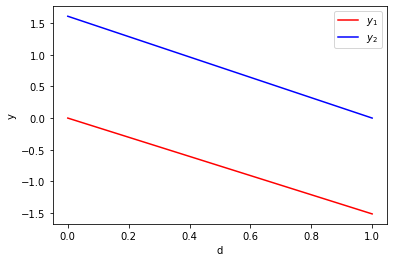

Theta: -1.516134162287278 Eta: 1.6108770149619416


In [135]:
# Test estimator on Linear-Gaussian model
def linear_gaussian_model(x, theta, eta):
    """
    Linear Gaussian model with analytical solution for eig:
    [y1, y2] = [d, 0; 0, 1-d] * [theta, eta]
    Parameters
    ----------
    x: (Nx, x_dim) input locations, or operating conditions
    theta: (Ns, Nx, theta_dim) model parameters
    eta: (Nr, Nx, eta_dim) nuisance parameters

    Nr: Number of realizations of nuisance parameters
    Ns: Number of samples of model parameters
    Nx: Number of input locations
    y_dim: Dimension of output
    theta_dim: Dimension of model parameters
    eta_dim: Dimension of nuisance parameters

    Returns
    -------
    g_theta: (Ns, Nr, Nx, y_dim) model output
    """
    Nx = x.shape[0]
    Ns = theta.shape[0]
    Nr = eta.shape[0]
    dim = 2

    y = np.zeros((Ns, Nr, Nx, dim))
    y1 = x[np.newaxis, :, 0] * theta[:, :, 0]  # (1, Nx) * (Ns, Nx) = (Ns, Nx)
    y1 = np.tile(y1[:, np.newaxis, :, np.newaxis], (1, Nr, 1, 1))  # (Ns, Nr, Nx, 1)
    y2 = (1 - x[np.newaxis, :, 0]) * eta[:, :, 0]  # (1, Nx) * (Nr, Nx) = (Nr, Nx)
    y2 = np.tile(y2[np.newaxis, :, :, np.newaxis], (Ns, 1, 1, 1))  # (Ns, Nr, Nx, 1)

    y = np.concatenate((y1, y2), axis=3)  # (Ns, Nr, Nx, 2)
    return y

# Analytical solution for linear gaussian model
def linear_gaussian_eig(d, var):
    return 0.5 * np.log(1 + d ** 2 / var)

def theta_sampler(Ns, Nx):
    """ Sample model parameters"""
    return np.random.randn(Ns, Nx, 1)

def eta_sampler(Nr, Nx):
    """ Sample nuisance parameters"""
    return np.random.randn(Nr, Nx, 1)

Nx = 50
x_loc = np.linspace(0, 1, Nx).reshape((Nx, 1))
theta = np.tile(theta_sampler(1, 1), (1, Nx, 1))
eta = np.tile(eta_sampler(1, 1), (1, Nx, 1))

y = linear_gaussian_model(x_loc, theta, eta)
y = np.squeeze(y)
plt.figure()
plt.plot(x_loc, y[:,0], '-r')
plt.plot(x_loc, y[:,1], '-b')
plt.legend((r'$y_1$', r'$y_2$'))
plt.xlabel('d')
plt.ylabel('y')
plt.show()
print(f'Theta: {np.squeeze(theta)[0]} Eta: {np.squeeze(eta)[0]}')

In [166]:
Ns = 200
Nr = 100
Nx = 50
x_loc = np.linspace(0, 1, Nx).reshape((Nx, 1))
var = 0.001
noise_cov = np.array([[var, 0], [0, var]])
eig = eig_nmc(Ns, Nr, x_loc, theta_sampler, eta_sampler, linear_gaussian_model, noise_cov)

Samples processed: 0 out of 200
Samples processed: 100 out of 200
Samples processed: 200 out of 200


In [167]:
eig_analytical = linear_gaussian_eig(x_loc, var)

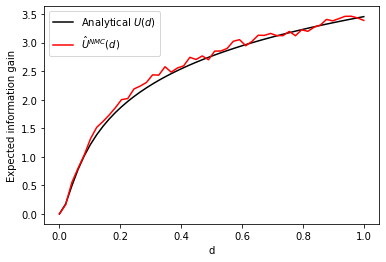

In [168]:
plt.figure()
plt.plot(x_loc, eig_analytical, '-k')
plt.plot(x_loc, eig, '-r')
plt.xlabel('d')
plt.ylabel('Expected information gain')
plt.legend((r'Analytical $U(d)$', r'$\hat{U}^{NMC}(d)$'))
plt.show()

In [ ]:
Ns = 1000  # number of outer loop samples
Nr = 100   # number of realizations
Ne = 576   # number of emitters
Nv = 50    # number of voltages to evaluate at

# Voltage prediction locations
voltage = np.linspace(800, 1850, Nv)
noise_var = np.max(exp_data[2,:])

# Nuisance parameters
subs = subs_sampler(Nr)
props = prop_sampler(Nr)
beams = beam_sampler(Nr)
geoms = np.loadtxt('../data/mr_geoms.dat', dtype=float, delimiter='\t').T.reshape(6, Ne, Nr)
emax_sim = np.loadtxt('../data/mr_geoms_tipE.dat', dtype=float, delimiter='\t').reshape(1, Ne, Nr)

# Model parameters
model_params = np.loadtxt('../data/Nr100_noPr_samples__2021_12_07T11_41_27.txt', dtype=float, delimiter='\t', skiprows=1)
np.random.shuffle(model_params)

In [34]:
y_i = np.random.randint(0, 3, (Ns, Nr, Nx, d))

In [37]:
y = y_i[np.newaxis, 0, :, :, :]
y.shape

(1, 3, 4, 2)

In [87]:
import matplotlib.colors as plt_col
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def scatter_matrix(samples, #list of chains
                   mins=None, maxs=None,
                   upper_right=None,
                   specials=None,
                   hist_plot=True, # if false then only data
                   nbins=200,
                   gamma=0.5,
                   labels=None,
                   perf_metric=None,
                   cmap='YlOrRd'):

    nchains = len(samples)
    dim = samples[0].shape[1]

    if mins is None:
        mins = np.zeros((dim))
        maxs = np.zeros((dim))

        for ii in range(dim):
            # print("ii = ", ii)
            mm = [np.quantile(samp[:, ii], 0.01, axis=0) for samp in samples]
            # print("\t mins = ", mm)
            mins[ii] = np.min(mm)
            mm = [np.quantile(samp[:, ii], 0.99, axis=0) for samp in samples]
            # print("\t maxs = ", mm)
            maxs[ii] = np.max(mm)

            if specials is not None:
                if isinstance(specials, list):
                    minspec = np.min([spec['vals'][ii] for spec in specials])
                    maxspec = np.max([spec['vals'][ii] for spec in specials])
                else:
                    minspec = specials['vals'][ii]
                    maxspec = specials['vals'][ii]
                mins[ii] = min(mins[ii], minspec)
                maxs[ii] = max(maxs[ii], maxspec)


    deltas = (maxs - mins) / 10.0
    use_mins = mins - deltas
    use_maxs = maxs + deltas

    cmuse = cm.get_cmap(name='jet')

    fig = plt.figure()
    if upper_right is None:
        gs = GridSpec(dim, dim, figure=fig)
        axs = [None]*dim*dim
        start = 0
        end = dim
        l = dim
    else:
        gs = GridSpec(dim+1, dim+1, figure=fig)
        axs = [None]*(dim+1)*(dim+1)
        start = 1
        end = dim + 1
        l = dim+1

    for ii in range(dim):
        # print("ii = ", ii)
        axs[ii] = fig.add_subplot(gs[ii+start, ii])
        ax = axs[ii]

        # Turn everythinng off
        if ii < dim-1:
            ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        else:
            ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)
            if labels:
                ax.set_xlabel(labels[ii])

        ax.tick_params(axis='y', left=False, right=False, labelleft=False)
        ax.set_frame_on(False)

        sampii = np.concatenate([samples[kk][:, ii] for kk in range(nchains)])
        for kk in range(nchains):
            ax.hist(sampii,
                    # ax.hist(samples[kk][:, ii],
                    bins='sturges',
                    density=True,
                    edgecolor='black',
                    stacked=True,
                    range=(use_mins[ii],use_maxs[ii]),
                    alpha=0.4)
        if specials is not None:
            for special in specials:
                if special['vals'][ii] is not None:
                    # ax.axvline(special[ii], color='red', lw=2)
                    if 'color' in special:
                        ax.axvline(special['vals'][ii], color=special['color'], lw=2)
#                         ax.axvline(special['vals2'][ii], color=special['color2'], lw=2)
                    else:
                        ax.axvline(special['vals'][ii], lw=2)

        ax.set_xlim((use_mins[ii]-1e-10, use_maxs[ii]+1e-10))

        for jj in range(ii+1, dim):
            # print("jj = ", jj)
            axs[jj*l + ii] = fig.add_subplot(gs[jj+start, ii])
            ax = axs[jj*l + ii]


            if jj < dim-1:
                ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
            else:
                ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)
                if labels:
                    ax.set_xlabel(labels[ii])
                    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
                    # ticks_loc = ax.get_xticks().tolist()
                    # ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
                    # ax.set_xticklabels(['{:.0f}'.format(x) for x in ticks_loc])
            if ii > 0:
                ax.tick_params(axis='y', left=False, right=False, labelleft=False)
            else:
                ax.tick_params(axis='y', left=True, right=False, labelleft=True)
                if labels:
                    ax.set_ylabel(labels[jj])
                    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
                    # ticks_loc = ax.get_yticks().tolist()
                    # ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
                    # ax.set_yticklabels(['{:.0f}'.format(y) for y in ticks_loc])

            ax.set_frame_on(True)

            for kk in range(nchains):
                if hist_plot is True:
                    ax.hist2d(samples[kk][:, ii], samples[kk][:, jj],
                              bins=nbins,
                              norm=mcolors.PowerNorm(gamma),
                              density=True,
                              cmap=cmuse)
                else:
                    if perf_metric is not None:
                        # alphas = np.ones(len(perf_metric))
                        # alphas[np.argwhere(perf_metric < 50)] = 0.2
                        sc = ax.scatter(samples[kk][:, ii], samples[kk][:, jj], s=1.5*np.ones(len(perf_metric)), c=perf_metric, cmap=cmap, norm=plt_col.LogNorm(vmin=1, vmax=np.max(perf_metric)), alpha=1)
                    else:
                        ax.plot(samples[kk][:, ii], samples[kk][:, jj], 'o', ms=1, alpha=gamma)

                # ax.hist2d(samples[kk][:, ii], samples[kk][:, jj], bins=nbins)

            if specials is not None:
                for special in specials:
                    if 'color' in special:
                        ax.plot(special['vals'][ii], special['vals'][jj], 'x',
                                color=special['color'], ms=4, mew=2)
#                         ax.plot(special['vals2'][ii], special['vals2'][jj], 'x',
#                                 color=special['color2'], ms=4, mew=2)
                    else:
                        ax.plot(special['vals'][ii], special['vals'][jj], 'x',
                                ms=4, mew=2)

            ax.set_xlim((use_mins[ii], use_maxs[ii]))
            ax.set_ylim((use_mins[jj]-1e-10, use_maxs[jj]+1e-10))

    plt.tight_layout(pad=0.01)
    if upper_right is not None:
        size_ur = int(dim/2)

        name = upper_right['name']
        vals = upper_right['vals']
        if 'log_transform' in upper_right:
            log_transform = upper_right['log_transform']
        else:
            log_transform = None
        ax = fig.add_subplot(gs[0:int(dim/2),
                                size_ur+1:size_ur+int(dim/2)+1])

        lb = np.min([np.quantile(val, 0.01) for val in vals])
        ub = np.max([np.quantile(val, 0.99) for val in vals])
        for kk in range(nchains):
            if log_transform is not None:
                pv = np.log10(vals[kk])
                ra = (np.log10(lb), np.log10(ub))
            else:
                pv = vals[kk]
                ra = (lb, ub)
            ax.hist(pv,
                    density=True,
                    range=ra,
                    edgecolor='black',
                    stacked=True,
                    bins='auto',
                    alpha=0.2)
        ax.tick_params(axis='x', bottom='both', top=False, labelbottom=True)
        ax.tick_params(axis='y', left='both', right=False, labelleft=False)
        ax.set_frame_on(True)
        ax.set_xlabel(name)
    plt.subplots_adjust(left=0.15, right=0.95)
    return fig, axs, gs